# Start-to-Finish Example: Gaussian pulse initial data for a massless scalar field, in Curvilinear coordinates

## Authors: Leonardo Werneck & Zach Etienne

# This tutorial notebook sets up initial data for a massless scalar field in *spherical-like coordinates*, using the *Numerical* ADM Spherical to BSSN Curvilinear initial data module (numerical = BSSN $\lambda^i$'s are computed using finite-difference derivatives instead of exact expressions).

**Notebook Status:** <font color='green'><b> Validated </b></font>

**Validation Notes:** This module has been validated to exhibit convergence to zero of the Hamiltonian constraint violation at the expected order to the exact solution (see [plots](#convergence) at bottom).</font>

## NRPy+ module to obtain the initial data used in this tutorial: **[ScalarFieldCollapse/ScalarField_InitialData.py](../edit/ScalarFieldCollapse/ScalarField_InitialData.py)**

## References

* [Tutorial-ADM_Initial_Data-ScalarField_GaussianPulse.ipynb](Tutorial-ADM_Initial_Data-ScalarField.ipynb)
* [Akbarian & Choptuik (2015)](https://arxiv.org/pdf/1508.01614.pdf) (Useful to understand the theoretical framework)
* [Baumgarte (2018)](https://arxiv.org/pdf/1807.10342.pdf) (Useful to understand the theoretical framework)
* [Baumgarte & Shapiro's Numerical Relativity](https://books.google.com.br/books/about/Numerical_Relativity.html?id=dxU1OEinvRUC&redir_esc=y): Section 6.2.2 (Useful to understand how to solve the Hamiltonian constraint)

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

* [Step 1](#set_nrpy_core): Set core NRPy+ parameters for numerical grids and reference metric
* [Step 2](#adm_id_scalar_field): Set up ADM initial data for the scalar field
* [Step 3](#adm_id_spacetime): Convert ADM initial data to BSSN-in-curvilinear coordinates
* [Step 4](#validate): Validating that the scalar field initial data satisfies the Hamiltonian constraint
    * [Step 4.a](#ham_const_output): Output the Hamiltonian constraint 
    * [Step 4.b](#bc_functs): Set up boundary condition functions for chosen singular, curvilinear coordinate system
    * [Step 4.c](#enforce3metric): Enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint
    * [Step 4.d](#cparams_rfm_and_domainsize): Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h`
* [Step 5](#mainc): `ScalarField_Playground.c`: The Main C Code
* [Step 6](#convergence): Validation: Convergence of numerical errors of the Scalar Field Collapse initial data (Hamiltonian constraint violation) to zero
* [Step 7](#latex_pdf_output): Output this module as $\LaTeX$-formatted PDF file

<a id='set_nrpy_core'></a>

# Step 1: Set core NRPy+ parameters for numerical grids and reference metric \[Back to [top](#toc)\]
$$\label{set_nrpy_core}$$

In [1]:
# Step P1: Import needed NRPy+ core modules:
from outputC import lhrh,outCfunction,outputC # NRPy+: Core C code output module
import NRPy_param_funcs as par   # NRPy+: Parameter interface
import sympy as sp               # SymPy: The Python computer algebra package upon which NRPy+ depends
import finite_difference as fin  # NRPy+: Finite difference C code generation module
import grid as gri               # NRPy+: Functions having to do with numerical grids
import indexedexp as ixp         # NRPy+: Symbolic indexed expression (e.g., tensors, vectors, etc.) support
import reference_metric as rfm   # NRPy+: Reference metric support
import cmdline_helper as cmd     # NRPy+: Multi-platform Python command-line interface
import shutil, os, sys           # Standard Python modules for multiplatform OS-level functions

# Step P2: Create C code output directory:
Ccodesdir = os.path.join("ScalarFieldID_Ccodes/")
# First remove C code output directory if it exists
# Courtesy https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty
# !rm -r ScalarWaveCurvilinear_Playground_Ccodes
shutil.rmtree(Ccodesdir, ignore_errors=True)
# Then create a fresh directory
cmd.mkdir(Ccodesdir)

# Step P3: Create executable output directory:
outdir = os.path.join(Ccodesdir,"output/")
cmd.mkdir(outdir)

thismodule = "ScalarFieldCollapse_ID_setup"

# Step 1: Set the spatial dimension parameter
#         to three this time, and then read
#         the parameter as DIM.
par.set_parval_from_str("grid::DIM",3)
DIM = par.parval_from_str("grid::DIM")

# Then we set the coordinate system for the numerical grid
par.set_parval_from_str("reference_metric::CoordSystem","SinhSpherical")
rfm.reference_metric() # Create ReU, ReDD needed for rescaling B-L initial data, generating BSSN RHSs, etc.

# Step 2: Set some core parameters, including CoordSystem MoL timestepping algorithm,
#                                 FD order, floating point precision, and CFL factor:
# Choices are: Spherical, SinhSpherical, SinhSphericalv2, Cylindrical, SinhCylindrical,
#              SymTP, SinhSymTP
CoordSystem     = "SinhSpherical"

# Step 2.a: Set defaults for Coordinate system parameters.
#           These are perhaps the most commonly adjusted parameters,
#           so we enable modifications at this high level.
domain_size = 15

# sinh_width sets the default value for:
#   * SinhSpherical's params.SINHW
#   * SinhCylindrical's params.SINHW{RHO,Z}
#   * SinhSymTP's params.SINHWAA
sinh_width      = 0.2 # If Sinh* coordinates chosen

# sinhv2_const_dr sets the default value for:
#   * SinhSphericalv2's params.const_dr
#   * SinhCylindricalv2's params.const_d{rho,z}
sinhv2_const_dr = 0.05# If Sinh*v2 coordinates chosen

# SymTP_bScale sets the default value for:
#   * SinhSymTP's params.bScale
SymTP_bScale    = 0.5 # If SymTP chosen

# Step 2.b: Set the order of spatial finite difference derivatives;
#           and the core data type.
FD_order  = 4        # Finite difference order: even numbers only, starting with 2. 12 is generally unstable
REAL      = "double" # Best to use double here.

# Step 3: Set the coordinate system for the numerical grid
par.set_parval_from_str("reference_metric::CoordSystem",CoordSystem)
rfm.reference_metric() # Create ReU, ReDD needed for rescaling B-L initial data, generating BSSN RHSs, etc.

# Step 4: Set the finite differencing order to FD_order (set above).
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", FD_order)

# Step 5: Set the directions=1,2 (theta,phi) axis to be the symmetry axis;
#         This sets all spatial derivatives in the thetha and phi directions to zero.
par.set_parval_from_str("indexedexp::symmetry_axes","12")

# Step 6: The MoLtimestepping interface is only used for memory allocation/deallocation
import MoLtimestepping.C_Code_Generation as MoL
from MoLtimestepping.RK_Butcher_Table_Dictionary import Butcher_dict
RK_method = "Euler" # DOES NOT MATTER; Again MoL interface is only used for memory alloc/dealloc.
RK_order  = Butcher_dict[RK_method][1]
cmd.mkdir(os.path.join(Ccodesdir,"MoLtimestepping/"))
MoL.MoL_C_Code_Generation(RK_method, RHS_string      = "", post_RHS_string = "",
    outdir = os.path.join(Ccodesdir,"MoLtimestepping/"))

<a id='adm_id_scalar_field'></a>

# Step 2: Set up ADM initial data for the scalar field \[Back to [top](#toc)\]
$$\label{adm_id_scalar_field}$$

As documented [in the time-symmetric Gaussian pulse scalar field initial data NRPy+ tutorial notebook](Tutorial-ScalarField-Gaussian_pulse_initial_data-time_symmetric.ipynb), we generate the scalar field initial data and output it to a file.

Our initial data solver requires space matrices methods which are implemented in SciPy, so we make sure that it is installed.

In [2]:
!pip install scipy > /dev/null

Next we call the [`ScalarField.ScalarField_time_symmetric_initial_data.py()` function](../edit/ScalarField/ScalarField_time_symmetric_initial_data.py) ([NRPy+ tutorial notebook](Tutorial-ScalarField-Gaussian_pulse_initial_data-time_symmetric.ipynb)) to set up the initial data, using the default parameters for initial data. This function outputs the solution to a file named "outputSFID.txt".

In [3]:
# Step 2.a: Import necessary Python and NRPy+ modules
import ScalarField.ScalarField_InitialData as sfid

# Step 2.b: Set the initial data parameters
outputfilename      = os.path.join(outdir,"SFID.txt")
initial_data_family = "Gaussian_pulse"
pulse_amplitude     = 0.1
pulse_center        = 0
pulse_width         = 1
Nr                  = 100000
rmax                = domain_size*1.5

# Step 2.c: Generate the initial data
sfid.ScalarField_InitialData(outputfilename,Ccodesdir,initial_data_family,
                             pulse_amplitude,pulse_center,pulse_width,Nr,rmax)

Generated the ADM initial data for the gravitational collapse 
of a massless scalar field in Spherical coordinates.

Type of initial condition: Scalar field: "Gaussian" Shell
                         ADM quantities: Time-symmetric
                        Lapse condition: Pre-collapsed
Parameters: amplitude         = 0.1,
            center            = 0,
            width             = 1,
            domain size       = 22.5,
            number of points  = 100000,
            Initial data file = ScalarFieldID_Ccodes/output/SFID.txt.

Wrote to file ScalarFieldID_Ccodes/ID_scalar_field_ADM_quantities.h
Wrote to file ScalarFieldID_Ccodes/ID_scalar_field_spherical.h
Appended to file "ScalarFieldID_Ccodes/ID_scalarfield_xx0xx1xx2_to_BSSN_xx0xx1xx2.h"
Appended to file "ScalarFieldID_Ccodes/ID_scalarfield_xx0xx1xx2_to_BSSN_xx0xx1xx2.h"


<a id='adm_id_spacetime'></a>

# Step 3: Convert ADM initial data to BSSN-in-curvilinear coordinates \[Back to [top](#toc)\]
$$\label{adm_id_spacetime}$$

This is an automated process, taken care of by [`BSSN.ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear`](../edit/BSSN.ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py), and documented [in this tutorial notebook](Tutorial-ADM_Initial_Data-Converting_Numerical_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear.ipynb).

In [4]:
import BSSN.ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear as AtoBnum
AtoBnum.Convert_Spherical_or_Cartesian_ADM_to_BSSN_curvilinear("Spherical","ID_scalar_field_ADM_quantities",
                                                               Ccodesdir=Ccodesdir,loopopts="")

Output C function ID_BSSN_lambdas() to file ScalarFieldID_Ccodes/ID_BSSN_lambdas.h
Output C function ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs() to file ScalarFieldID_Ccodes/ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs.h
Output C function ID_BSSN__ALL_BUT_LAMBDAs() to file ScalarFieldID_Ccodes/ID_BSSN__ALL_BUT_LAMBDAs.h


<a id='validate'></a>

# Step 4: Validating that the scalar field initial data satisfies the Hamiltonian constraint \[Back to [top](#toc)\]
$$\label{validate}$$

We will validate that the scalar field initial data satisfies the Hamiltonian constraint, modulo numerical finite differencing error.

<a id='ham_const_output'></a>

## Step 4.a: Output the Hamiltonian constraint \[Back to [top](#toc)\]
$$\label{ham_const_output}$$

First output the Hamiltonian constraint [as documented in the corresponding NRPy+ tutorial notebook](Tutorial-BSSN_constraints.ipynb)

In [5]:
# Enable rfm_precompute infrastructure, which results in
#   BSSN RHSs that are free of transcendental functions,
#   even in curvilinear coordinates, so long as
#   ConformalFactor is set to "W" (default).
cmd.mkdir(os.path.join(Ccodesdir,"rfm_files/"))
par.set_parval_from_str("reference_metric::enable_rfm_precompute","True")
par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir",os.path.join(Ccodesdir,"rfm_files/"))

import BSSN.Enforce_Detgammabar_Constraint as EGC
enforce_detg_constraint_symb_expressions = EGC.Enforce_Detgammabar_Constraint_symb_expressions()


# Now register the Hamiltonian as a gridfunction.
H = gri.register_gridfunctions("AUX","H")

# Declare scalar field gridfunctions
import ScalarField.ScalarField_declare_gridfunctions as sfgfs
sf,sfM = sfgfs.declare_scalar_field_gridfunctions_if_not_declared_already()

# Compute the scalar field energy-momentum tensor
import ScalarField.ScalarField_Tmunu as sfTmunu
sfTmunu.ScalarField_Tmunu()
T4UU = sfTmunu.T4UU

# Then define the Hamiltonian constraint and output the optimized C code.
import BSSN.BSSN_constraints as bssncon
import BSSN.BSSN_stress_energy_source_terms as Bsest
bssncon.BSSN_constraints(add_T4UUmunu_source_terms=False)
Bsest.BSSN_source_terms_for_BSSN_constraints(T4UU)
bssncon.H += Bsest.sourceterm_H

# Now that we are finished with all the rfm hatted
#           quantities in generic precomputed functional
#           form, let's restore them to their closed-
#           form expressions.
par.set_parval_from_str("reference_metric::enable_rfm_precompute","False") # Reset to False to disable rfm_precompute.
rfm.ref_metric__hatted_quantities()

desc="Evaluate the Hamiltonian constraint"
name="Hamiltonian_constraint"
outCfunction(
    outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
    params   = """rfm_struct *restrict rfmstruct,const paramstruct *restrict params,
                  REAL *restrict in_gfs, REAL *restrict auxevol_gfs, REAL *restrict aux_gfs""",
    body     = fin.FD_outputC("returnstring",lhrh(lhs=gri.gfaccess("aux_gfs", "H"), rhs=bssncon.H),
                              params="outCverbose=False").replace("IDX4","IDX4S"),
    loopopts = "InteriorPoints,Enable_rfm_precompute")

Output C function Hamiltonian_constraint() to file ScalarFieldID_Ccodes/Hamiltonian_constraint.h


<a id='bc_functs'></a>

## Step 4.b: Set up boundary condition functions for chosen singular, curvilinear coordinate system \[Back to [top](#toc)\]
$$\label{bc_functs}$$

Next apply singular, curvilinear coordinate boundary conditions [as documented in the corresponding NRPy+ tutorial notebook](Tutorial-Start_to_Finish-Curvilinear_BCs.ipynb).

In [6]:
import CurviBoundaryConditions.CurviBoundaryConditions as cbcs
cbcs.Set_up_CurviBoundaryConditions(os.path.join(Ccodesdir,"boundary_conditions/"),Cparamspath=os.path.join("../"))

Wrote to file "ScalarFieldID_Ccodes/boundary_conditions/parity_conditions_symbolic_dot_products.h"
Evolved parity: ( aDD00:4, aDD01:5, aDD02:6, aDD11:7, aDD12:8, aDD22:9,
    alpha:0, betU0:1, betU1:2, betU2:3, cf:0, hDD00:4, hDD01:5, hDD02:6,
    hDD11:7, hDD12:8, hDD22:9, lambdaU0:1, lambdaU1:2, lambdaU2:3, sf:0,
    sfM:0, trK:0, vetU0:1, vetU1:2, vetU2:3 )
Auxiliary parity: ( H:0 )

Wrote to file "ScalarFieldID_Ccodes/boundary_conditions/EigenCoord_Cart_to_xx.h"


<a id='enforce3metric'></a>

## Step 4.c: Enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint \[Back to [top](#toc)\]
$$\label{enforce3metric}$$

Then enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint (Eq. 53 of [Ruchlin, Etienne, and Baumgarte (2018)](https://arxiv.org/abs/1712.07658)), as [documented in the corresponding NRPy+ tutorial notebook](Tutorial-BSSN-Enforcing_Determinant_gammabar_equals_gammahat_Constraint.ipynb).

Applying curvilinear boundary conditions should affect the initial data at the outer boundary, and will in general cause the $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint to be violated there. Thus after we apply these boundary conditions, we must always call the routine for enforcing the $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint:

In [7]:
# Set up the C function for the det(gammahat) = det(gammabar)
EGC.output_Enforce_Detgammabar_Constraint_Ccode(Ccodesdir,
                                                exprs=enforce_detg_constraint_symb_expressions)

Output C function enforce_detgammabar_constraint() to file ScalarFieldID_Ccodes/enforce_detgammabar_constraint.h


<a id='cparams_rfm_and_domainsize'></a>

## Step 4.d: Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h` \[Back to [top](#toc)\]
$$\label{cparams_rfm_and_domainsize}$$

Based on declared NRPy+ Cparameters, first we generate `declare_Cparameters_struct.h`, `set_Cparameters_default.h`, and `set_Cparameters[-SIMD].h`.

Then we output `free_parameters.h`, which sets initial data parameters, as well as grid domain & reference metric parameters, applying `domain_size` and `sinh_width`/`SymTP_bScale` (if applicable) as set above

In [8]:
# Step 3.d.i: Generate declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes(os.path.join(Ccodesdir))

# Step 3.d.ii: Set free_parameters.h
# Output to $Ccodesdir/free_parameters.h reference metric parameters based on generic
#    domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale,
#    parameters set above.
rfm.out_default_free_parameters_for_rfm(os.path.join(Ccodesdir,"free_parameters.h"),
                                        domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale)

# Step 3.d.iii: Generate set_Nxx_dxx_invdx_params__and__xx.h:
rfm.set_Nxx_dxx_invdx_params__and__xx_h(Ccodesdir)

# Step 3.d.iv: Generate xx_to_Cart.h, which contains xx_to_Cart() for
#               (the mapping from xx->Cartesian) for the chosen
#               CoordSystem:
rfm.xx_to_Cart_h("xx_to_Cart","./set_Cparameters.h",os.path.join(Ccodesdir,"xx_to_Cart.h"))

# Step 3.d.v: Generate declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes(os.path.join(Ccodesdir))

<a id='mainc'></a>

# Step 5: `ScalarField_Playground.c`: The Main C Code \[Back to [top](#toc)\]
$$\label{mainc}$$

In [9]:
# Part P0: Define REAL, set the number of ghost cells NGHOSTS (from NRPy+'s FD_CENTDERIVS_ORDER)

with open(os.path.join(Ccodesdir,"ScalarField_Playground_REAL__NGHOSTS.h"), "w") as file:
    file.write("""
// Part P0.a: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
#define NGHOSTS """+str(int(FD_order/2)+1)+"""
// Part P0.b: Set the numerical precision (REAL) to double, ensuring all floating point
//            numbers are stored to at least ~16 significant digits
#define REAL """+REAL+"\n")

In [10]:
%%writefile $Ccodesdir/ScalarField_Playground.c


// Step P0: Define REAL and NGHOSTS. This header is generated by NRPy+.
#include "ScalarField_Playground_REAL__NGHOSTS.h"

#include "rfm_files/rfm_struct__declare.h"

#include "declare_Cparameters_struct.h"

// Step P1: Import needed header files
#include "stdio.h"
#include "stdlib.h"
#include "math.h"
#ifndef M_PI
#define M_PI 3.141592653589793238462643383279502884L
#endif
#ifndef M_SQRT1_2
#define M_SQRT1_2 0.707106781186547524400844362104849039L
#endif

// Step P2: Declare the IDX4S(gf,i,j,k) macro, which enables us to store 4-dimensions of
//           data in a 1D array. In this case, consecutive values of "i"
//           (all other indices held to a fixed value) are consecutive in memory, where
//           consecutive values of "j" (fixing all other indices) are separated by
//           Nxx_plus_2NGHOSTS0 elements in memory. Similarly, consecutive values of
//           "k" are separated by Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1 in memory, etc.
#define IDX4S(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) + Nxx_plus_2NGHOSTS2 * (g) ) ) )
#define IDX4ptS(g,idx) ( (idx) + (Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2) * (g) )
#define IDX3S(i,j,k) ( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) ) ) )
#define LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++)
#define LOOP_ALL_GFS_GPS(ii) _Pragma("omp parallel for") \
  for(int (ii)=0;(ii)<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;(ii)++)

// Step P3: Set gridfunctions macros
#include "boundary_conditions/gridfunction_defines.h"

// Step P4: Set xx_to_Cart(const paramstruct *restrict params,
//                     REAL *restrict xx[3],
//                     const int i0,const int i1,const int i2,
//                     REAL xCart[3]),
//           which maps xx->Cartesian via
//    {xx[0][i0],xx[1][i1],xx[2][i2]}->{xCart[0],xCart[1],xCart[2]}
#include "xx_to_Cart.h"

// Step P5: Defines set_Nxx_dxx_invdx_params__and__xx(const int EigenCoord, const int Nxx[3],
//                                       paramstruct *restrict params, REAL *restrict xx[3]),
//          which sets params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for
//          the chosen Eigen-CoordSystem if EigenCoord==1, or
//          CoordSystem if EigenCoord==0.
#include "set_Nxx_dxx_invdx_params__and__xx.h"

// Step P6: Include basic functions needed to impose curvilinear
//          parity and boundary conditions.
#include "boundary_conditions/CurviBC_include_Cfunctions.h"

// Step P7: Include function for enforcing detgammabar constraint.
#include "enforce_detgammabar_constraint.h"

// Step P8: Declare initial data input struct:
//          stores data from initial data solver,
//          so they can be put on the numerical grid.
typedef struct __ID_inputs {
    int interp_stencil_size;
    int numlines_in_file;
    REAL *r_arr,*sf_arr,*psi4_arr,*alpha_arr;
} ID_inputs;

// Part P9: Declare all functions for setting up ScalarField initial data.
/* Routines to interpolate the ScalarField solution and convert to ADM & T^{munu}: */
#include "../ScalarField/ScalarField_interp.h"
#include "ID_scalar_field_ADM_quantities.h"
#include "ID_scalar_field_spherical.h"
#include "ID_scalarfield_xx0xx1xx2_to_BSSN_xx0xx1xx2.h"
#include "ID_scalarfield.h"

/* Next perform the basis conversion and compute all needed BSSN quantities */
#include "ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs.h"
#include "ID_BSSN__ALL_BUT_LAMBDAs.h"
#include "ID_BSSN_lambdas.h"

// Step P10: Set the generic driver function for setting up BSSN initial data
void initial_data(const paramstruct *restrict params,const bc_struct *restrict bcstruct,
                  const rfm_struct *restrict rfmstruct,
                  REAL *restrict xx[3], REAL *restrict auxevol_gfs, REAL *restrict in_gfs) {
#include "set_Cparameters.h"

    // Step 1: Set up ScalarField initial data
    // Step 1.a: Read ScalarField initial data from data file
    // Open the data file:
    char filename[100];
    sprintf(filename,"./SFID.txt");
    FILE *fp = fopen(filename, "r");
    if (fp == NULL) {
        fprintf(stderr,"ERROR: could not open file %s\n",filename);
        exit(1);
    }
    // Count the number of lines in the data file:
    int numlines_in_file = count_num_lines_in_file(fp);
    // Allocate space for all data arrays:
    REAL *r_arr     = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *sf_arr    = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *psi4_arr  = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *alpha_arr = (REAL *)malloc(sizeof(REAL)*numlines_in_file);

    // Read from the data file, filling in arrays
    // read_datafile__set_arrays() may be found in ScalarField/ScalarField_interp.h
    if(read_datafile__set_arrays(fp,r_arr,sf_arr,psi4_arr,alpha_arr) == 1) {
        fprintf(stderr,"ERROR WHEN READING FILE %s!\n",filename);
        exit(1);
    }
    fclose(fp);

    const int interp_stencil_size = 12;
    ID_inputs SF_in;
    SF_in.interp_stencil_size = interp_stencil_size;
    SF_in.numlines_in_file    = numlines_in_file;
    SF_in.r_arr               = r_arr;
    SF_in.sf_arr              = sf_arr;
    SF_in.psi4_arr            = psi4_arr;
    SF_in.alpha_arr           = alpha_arr;

    // Step 1.b: Interpolate data from data file to set BSSN gridfunctions
    ID_scalarfield(params,xx,SF_in, in_gfs);
    ID_BSSN__ALL_BUT_LAMBDAs(params,xx,SF_in, in_gfs);
    apply_bcs_curvilinear(params, bcstruct, NUM_EVOL_GFS, evol_gf_parity, in_gfs);
    enforce_detgammabar_constraint(rfmstruct, params,                   in_gfs);
    ID_BSSN_lambdas(params, xx, in_gfs);
    apply_bcs_curvilinear(params, bcstruct, NUM_EVOL_GFS, evol_gf_parity, in_gfs);
    enforce_detgammabar_constraint(rfmstruct, params,                   in_gfs);

    free(r_arr);
    free(sf_arr);
    free(psi4_arr);
    free(alpha_arr);
}

// Step P11: Declare function for evaluating Hamiltonian constraint (diagnostic)
#include "Hamiltonian_constraint.h"

// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up initial data to an exact solution
// Step 2: Start the timer, for keeping track of how fast the simulation is progressing.
// Step 3: Integrate the initial data forward in time using the chosen RK-like Method of
//         Lines timestepping algorithm, and output periodic simulation diagnostics
// Step 3.a: Output 2D data file periodically, for visualization
// Step 3.b: Step forward one timestep (t -> t+dt) in time using
//           chosen RK-like MoL timestepping algorithm
// Step 3.c: If t=t_final, output conformal factor & Hamiltonian
//           constraint violation to 2D data file
// Step 3.d: Progress indicator printing to stderr
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {
    paramstruct params;
#include "set_Cparameters_default.h"

    // Step 0a: Read command-line input, error out if nonconformant
    if((argc != 4) || atoi(argv[1]) < NGHOSTS || atoi(argv[2]) < 2 || atoi(argv[3]) < 2 /* FIXME; allow for axisymmetric sims */) {
        fprintf(stderr,"Error: Expected three command-line arguments: ./ScalarField_Playground Nx0 Nx1 Nx2,\n");
        fprintf(stderr,"where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
        fprintf(stderr,"Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
        exit(1);
    }
    // Step 0b: Set up numerical grid structure, first in space...
    const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
    if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
        fprintf(stderr,"Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
        fprintf(stderr,"       For example, in case of angular directions, proper symmetry zones will not exist.\n");
        exit(1);
    }

    // Step 0c: Set free parameters, overwriting Cparameters defaults
    //          by hand or with command-line input, as desired.
#include "free_parameters.h"

   // Step 0d: Uniform coordinate grids are stored to *xx[3]
    REAL *xx[3];
    // Step 0d.i: Set bcstruct
    bc_struct bcstruct;
    {
        int EigenCoord = 1;
        // Step 0d.ii: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
        //             params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
        //             chosen Eigen-CoordSystem.
        set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &params, xx);
        // Step 0d.iii: Set Nxx_plus_2NGHOSTS_tot
#include "set_Cparameters-nopointer.h"
        const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;
        // Step 0e: Find ghostzone mappings; set up bcstruct
#include "boundary_conditions/driver_bcstruct.h"
        // Step 0e.i: Free allocated space for xx[][] array
        for(int i=0;i<3;i++) free(xx[i]);
    }

    // Step 0f: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //          params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //          chosen (non-Eigen) CoordSystem.
    int EigenCoord = 0;
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &params, xx);

    // Step 0g: Set all C parameters "blah" for params.blah, including
    //          Nxx_plus_2NGHOSTS0 = params.Nxx_plus_2NGHOSTS0, etc.
#include "set_Cparameters-nopointer.h"
    const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;

    // Step 0j: Error out if the number of auxiliary gridfunctions outnumber evolved gridfunctions.
    //              This is a limitation of the RK method. You are always welcome to declare & allocate
    //              additional gridfunctions by hand.
    if(NUM_AUX_GFS > NUM_EVOL_GFS) {
        fprintf(stderr,"Error: NUM_AUX_GFS > NUM_EVOL_GFS. Either reduce the number of auxiliary gridfunctions,\n");
        fprintf(stderr,"       or allocate (malloc) by hand storage for *diagnostic_output_gfs. \n");
        exit(1);
    }

    // Step 0k: Allocate memory for gridfunctions
#include "MoLtimestepping/RK_Allocate_Memory.h"
    REAL *restrict auxevol_gfs = (REAL *)malloc(sizeof(REAL) * NUM_AUXEVOL_GFS * Nxx_plus_2NGHOSTS_tot);

    // Step 0l: Set up precomputed reference metric arrays
    // Step 0l.i: Allocate space for precomputed reference metric arrays.
#include "rfm_files/rfm_struct__malloc.h"

    // Step 0l.ii: Define precomputed reference metric arrays.
    {
    #include "set_Cparameters-nopointer.h"
    #include "rfm_files/rfm_struct__define.h"
    }

    // Step 1: Set up initial data
    initial_data(&params,&bcstruct, &rfmstruct, xx, auxevol_gfs, y_n_gfs);
    // Step 1a: Compute the energy-momentum tensor

    // Step 1b: Apply boundary conditions, as initial data
    //          are sometimes ill-defined in ghost zones.
    //          E.g., spherical initial data might not be
    //          properly defined at points where r=-1.
    apply_bcs_curvilinear(&params, &bcstruct, NUM_EVOL_GFS,evol_gf_parity, y_n_gfs);
    enforce_detgammabar_constraint(&rfmstruct, &params, y_n_gfs);

    // Evaluate Hamiltonian constraint violation
    Hamiltonian_constraint(&rfmstruct, &params, y_n_gfs,auxevol_gfs, diagnostic_output_gfs);
    char filename[100];
    sprintf(filename,"out%d.txt",Nxx[0]);
    FILE *out1D = fopen(filename, "w");
    const int i1mid = Nxx_plus_2NGHOSTS1/2;
    const int i2mid = Nxx_plus_2NGHOSTS2/2;
    for(int i0=NGHOSTS;i0<Nxx_plus_2NGHOSTS0-NGHOSTS;i0++) {
        REAL xCart[3];
        xx_to_Cart(&params,xx,i0,i1mid,i2mid,xCart);
        int idx = IDX3S(i0,i1mid,i2mid);
        REAL rr = sqrt( xCart[0]*xCart[0] + xCart[1]*xCart[1] + xCart[2]*xCart[2] );
        fprintf(out1D,"%e %e\n",rr,log10(fabs(diagnostic_output_gfs[IDX4ptS(HGF,idx)])));
    }
    fclose(out1D);

    // Step 4: Free all allocated memory
#include "rfm_files/rfm_struct__freemem.h"
#include "boundary_conditions/bcstruct_freemem.h"
#include "MoLtimestepping/RK_Free_Memory.h"
    free(auxevol_gfs);
    for(int i=0;i<3;i++) free(xx[i]);

    return 0;
}

Writing ScalarFieldID_Ccodes//ScalarField_Playground.c


In [11]:
import cmdline_helper as cmd
cmd.C_compile(os.path.join(Ccodesdir,"ScalarField_Playground.c"),
              os.path.join(outdir,"ScalarField_Playground"),compile_mode="optimized")
              
os.chdir(outdir)
cmd.delete_existing_files("out96.txt")
cmd.Execute("ScalarField_Playground", "96 2 2", "out96.txt")
cmd.delete_existing_files("out72.txt")
cmd.Execute("ScalarField_Playground", "72 2 2", "out72.txt")
cmd.delete_existing_files("out48.txt")
cmd.Execute("ScalarField_Playground", "48 2 2", "out48.txt")
os.chdir(os.path.join("..",".."))

Compiling executable...
(EXEC): Executing `gcc -std=gnu99 -Ofast -fopenmp -march=native -funroll-loops ScalarFieldID_Ccodes/ScalarField_Playground.c -o ScalarFieldID_Ccodes/output/ScalarField_Playground -lm`...
(BENCH): Finished executing in 2.8425137996673584 seconds.
Finished compilation.
(EXEC): Executing `./ScalarField_Playground 96 2 2`...
(BENCH): Finished executing in 1.4379079341888428 seconds.
(EXEC): Executing `./ScalarField_Playground 72 2 2`...
(BENCH): Finished executing in 0.2141411304473877 seconds.
(EXEC): Executing `./ScalarField_Playground 48 2 2`...
(BENCH): Finished executing in 0.2116990089416504 seconds.


<a id='convergence'></a>

# Step 6: Validation: Convergence of numerical errors (Hamiltonian constraint violation) to zero \[Back to [top](#toc)\]
$$\label{convergence}$$

The equations behind these initial data solve Einstein's equations exactly, at a single instant in time. One reflection of this solution is that the Hamiltonian constraint violation should be exactly zero in the initial data. 

However, when evaluated on numerical grids, the Hamiltonian constraint violation will *not* generally evaluate to zero due to the associated numerical derivatives not being exact. However, these numerical derivatives (finite difference derivatives in this case) should *converge* to the exact derivatives as the density of numerical sampling points approaches infinity.

In this case, all of our finite difference derivatives agree with the exact solution, with an error term that drops with the uniform gridspacing to the fourth power: $\left(\Delta x^i\right)^4$. 

Here, as in the [Start-to-Finish Scalar Wave (Cartesian grids) NRPy+ tutorial](Tutorial-Start_to_Finish-ScalarWave.ipynb) and the [Start-to-Finish Scalar Wave (curvilinear grids) NRPy+ tutorial](Tutorial-Start_to_Finish-ScalarWaveCurvilinear.ipynb) we confirm this convergence.

We demonstrate convergence along the radial direction in our 1D (spherically symmetric) problem.

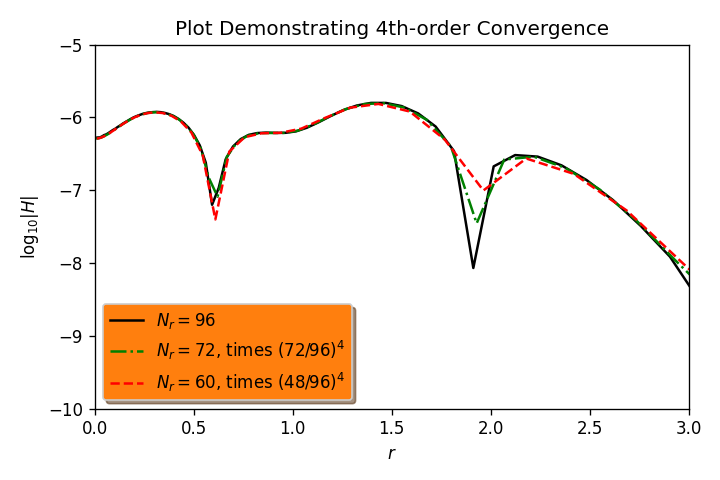

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

r_96,log10H_96 = np.loadtxt(os.path.join(outdir,"out96.txt")).T
r_72,log10H_72 = np.loadtxt(os.path.join(outdir,"out72.txt")).T
r_48,log10H_48 = np.loadtxt(os.path.join(outdir,"out48.txt")).T

# Set 4 subplots
fig = plt.figure()

plt.title("Plot Demonstrating 4th-order Convergence")
plt.ylabel(r"$\log_{10}|H|$")
plt.xlabel(r"$r$")
plt.xlim(0,3)
plt.ylim(-10,-5)
plt.plot(r_96,log10H_96,color='black',ls='-',label=r"$N_{r}=96$")
plt.plot(r_72,log10H_72+np.log10((72.0/96.0)**4),color='green',ls='-.',label=r"$N_{r}=72$, times (72/96)$^4$")
plt.plot(r_48,log10H_48+np.log10((48.0/96.0)**4),color='red',ls='--',label=r"$N_{r}=60$, times (48/96)$^4$")
legend = plt.legend(shadow=True,loc=3)
legend.get_frame().set_facecolor('C1')
plt.tight_layout()

outfile = os.path.join(outdir,"HC_convergence_SFID.png")
plt.savefig(outfile,facecolor='white',dpi=120)
plt.close(fig)
Image(outfile)

<a id='latex_pdf_output'></a>

# Step 7: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_ScalarField_initial_data.pdf](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_ScalarField_initial_data.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [13]:
import cmdline_helper as cmd # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_ScalarField_initial_data")

Created Tutorial-Start_to_Finish-BSSNCurvilinear-
    Setting_up_ScalarField_initial_data.tex, and compiled LaTeX file to PDF
    file Tutorial-Start_to_Finish-BSSNCurvilinear-
    Setting_up_ScalarField_initial_data.pdf
